In [30]:
from numba import njit
import numpy as np
import agentpy as ap
import networkx as nx
import random

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import IPython

In [62]:
class Person(ap.Agent):

    def setup(self):
        """ Initialize a new variable at agent creation. """
        self.condition = 0  # Susceptible = 0, Infected = 1, Recovered = 2

    def being_sick(self):
        """ Spread disease to peers in the network. """
        rng = self.model.random
        for n in self.network.neighbors(self):
            if n.condition == 0 and self.p.infection_chance > rng.random():
                n.condition = 1  # Infect susceptible peer
        if self.p.recovery_chance > rng.random():
            self.condition = 2  # Recover from infection

In [84]:
class VirusModel(ap.Model):

    def setup(self):
        """ Initialize the agents and network of the model. """

        # Prepare a small-world network
        graph = nx.watts_strogatz_graph(
            self.p.population,
            self.p.number_of_neighbors,
            self.p.network_randomness)

        # Create agents and network
        self.agents = ap.AgentList(self, self.p.population, Person)
        self.network = self.agents.network = ap.Network(self, graph)
        self.network.add_agents(self.agents, self.network.nodes)

        # Infect a random share of the population
        I0 = int(self.p.initial_infection_share * self.p.population)
        self.agents.random(I0).condition = 1

    def update(self):
        """ Record variables after setup and each step. """

        # Record share of agents with each condition
        for i, c in enumerate(('S', 'I', 'R')):
            n_agents = len(self.agents.select(self.agents.condition == i))
            self[c] = n_agents / self.p.population
            self.record(c)

        # # Stop simulation if disease is gone
        # if self.I == 0:
        #     self.stop()

    def step(self):
        """ Define the models' events per simulation step. """

        # Call 'being_sick' for infected agents
        self.agents.select(self.agents.condition == 1).being_sick()

    def end(self):
        """ Record evaluation measures at the end of the simulation. """

        # Record final evaluation measures
        self.report('Total share infected', self.I + self.R)
        self.report('Peak share infected', max(self.log['I']))
        self.report('Final share recovered', self.R)
        self.report('Final share infected', self.I)

In [57]:
# parameters = {
#     'population': 6000,
#     'infection_chance': 0.6162437405549541,
#     'recovery_chance': 0.08875872018545582,
#     'initial_infection_share': 0.20,
#     'number_of_neighbors': 6,
#     'network_randomness': 0.8,
#     'steps': 100
# }

# model = VirusModel(parameters)
# results = model.run()

parameters = {
    'population': 1000,
    'infection_chance': 0.3,
    'recovery_chance': 0.1,
    'initial_infection_share': 0.1,
    'number_of_neighbors': 2,
    'network_randomness': 0.5
}

model = VirusModel(parameters)
results = model.run()

Completed: 94 steps
Run time: 0:00:00.099759
Simulation finished


In [58]:
results

DataDict {
'info': Dictionary with 9 keys
'parameters': 
    'constants': Dictionary with 6 keys
'variables': 
    'VirusModel': DataFrame with 3 variables and 95 rows
'reporters': DataFrame with 5 variables and 1 row
}

In [59]:
results.variables.VirusModel.head(-10)

S      I      R
t                      
0   0.900  0.100  0.000
1   0.844  0.146  0.010
2   0.793  0.181  0.026
3   0.755  0.201  0.044
4   0.710  0.221  0.069
..    ...    ...    ...
80  0.371  0.002  0.627
81  0.371  0.001  0.628
82  0.371  0.001  0.628
83  0.371  0.001  0.628
84  0.371  0.001  0.628

[85 rows x 3 columns]

In [60]:
results.reporters

seed  Total share infected  \
0  281959290258905450320868393929625723816                 0.629   

   Peak share infected  Final share recovered  Final share infected  
0                0.241                  0.629                   0.0

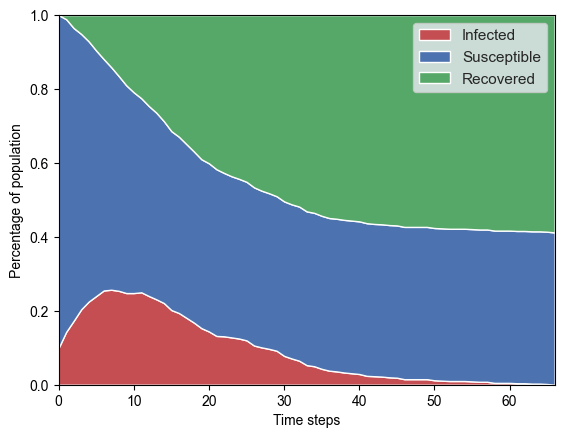

In [41]:
def virus_stackplot(data, ax):
    """ Stackplot of people's condition over time. """
    x = data.index.get_level_values('t')
    y = [data[var] for var in ['I', 'S', 'R']]

    sns.set()
    ax.stackplot(x, y, labels=['Infected', 'Susceptible', 'Recovered'],
                 colors = ['r', 'b', 'g'])

    ax.legend()
    ax.set_xlim(0, max(1, len(x)-1))
    ax.set_ylim(0, 1)
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Percentage of population")

fig, ax = plt.subplots()
virus_stackplot(results.variables.VirusModel, ax)

In [42]:
def animation_plot(m, axs):
    ax1, ax2 = axs
    ax1.set_title("Virus spread")
    ax2.set_title(f"Share infected: {m.I}")

    # Plot stackplot on first axis
    virus_stackplot(m.output.variables.VirusModel, ax1)

    # Plot network on second axis
    color_dict = {0:'b', 1:'r', 2:'g'}
    colors = [color_dict[c] for c in m.agents.condition]
    nx.draw_circular(m.network.graph, node_color=colors,
                     node_size=50, ax=ax2)

fig, axs = plt.subplots(1, 2, figsize=(8, 4)) # Prepare figure
parameters['population'] = 50 # Lower population for better visibility
animation = ap.animate(VirusModel(parameters), fig, axs, animation_plot)

In [43]:
def animation_plot(m, axs):
    ax1, ax2 = axs
    ax1.set_title("Virus spread")
    ax2.set_title(f"Share infected: {m.I}")

    # Plot stackplot on first axis
    virus_stackplot(m.output.variables.VirusModel, ax1)

    # Plot network on second axis
    color_dict = {0:'b', 1:'r', 2:'g'}
    colors = [color_dict[c] for c in m.agents.condition]
    nx.draw_circular(m.network.graph, node_color=colors,
                     node_size=50, ax=ax2)

fig, axs = plt.subplots(1, 2, figsize=(8, 4)) # Prepare figure
parameters['population'] = 50 # Lower population for better visibility
animation = ap.animate(VirusModel(parameters), fig, axs, animation_plot)

/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [44]:
IPython.display.HTML(animation.to_jshtml())


In [85]:
parameters = {
    'population': 4000,
    'infection_chance': ap.Range(0.1, 1.),
    'recovery_chance': ap.Range(0.1, 1.),
    'initial_infection_share': 0.15,
    'number_of_neighbors': 4,
    'network_randomness': ap.Range(0., 1.),
    'steps': 100
}

sample = ap.Sample(
    parameters,
    n=128,
    method='saltelli',
    calc_second_order=False
)

In [86]:
exp = ap.Experiment(VirusModel, sample, iterations=10)
results = exp.run()

Scheduled runs: 6400
Completed: 6400, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:41:26.534435


In [66]:
results

DataDict {
'info': Dictionary with 12 keys
'parameters': 
    'constants': Dictionary with 2 keys
    'sample': DataFrame with 4 variables and 768 rows
    'log': Dictionary with 5 keys
'reporters': DataFrame with 5 variables and 7680 rows
}

In [87]:
results.reporters

seed  \
sample_id iteration                                            
0         0           48047303427449166720071768480103597699   
          1          269985684941608138937550349997165791054   
          2          206828208704881264311881775445874083507   
          3           36782872473932861111750456021519626647   
          4          140871535128915818823844249778667329260   
...                                                      ...   
639       5            7513274339146290282433903301932735724   
          6          247064915524102286744753811408087001438   
          7          270723075274885328114946405639190326434   
          8          108489508810048594079911226319084434401   
          9          247540547035503415986117847288265115097   

                     Total share infected  Peak share infected  \
sample_id iteration                                              
0         0                       0.38550              0.15125   
          1                       0.38775              0.15000   
          2                       0.38775              0.15000   
          3                       0.38100              0.15050   
          4                       0.36550              0.15000   
...                                   ...                  ...   
639       5                       0.97675              0.41950   
          6                       0.97575              0.40850   
          7                       0.97800              0.40450   
          8                       0.98100              0.40325   
          9                       0.97875              0.41225   

                     Final share recovered  Final share infected  
sample_id iteration                                               
0         0                        0.38550                   0.0  
          1                        0.38775                   0.0  
          2                        0.38775                   0.0  
          3                        0.38100                   0.0  
          4                        0.36550                   0.0  
...                                    ...                   ...  
639       5                        0.97675                   0.0  
          6                        0.97575                   0.0  
          7                        0.97800                   0.0  
          8                        0.98100                   0.0  
          9                        0.97875                   0.0  

[6400 rows x 5 columns]

array([[<Axes: title={'center': 'Total share infected'}>,
        <Axes: title={'center': 'Peak share infected'}>],
       [<Axes: title={'center': 'Final share recovered'}>,
        <Axes: title={'center': 'Final share infected'}>]], dtype=object)

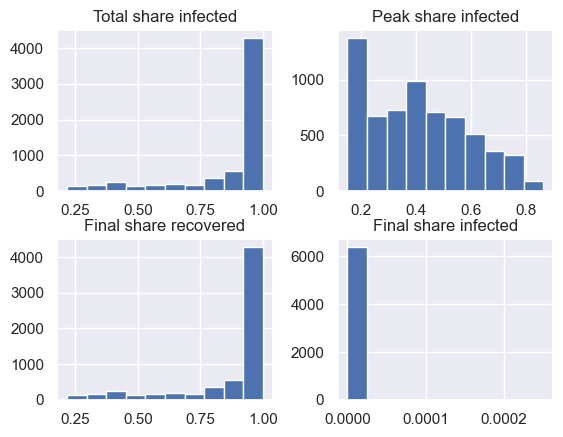

In [88]:
results.reporters.hist()

In [89]:
results.calc_sobol()

DataDict {
'info': Dictionary with 12 keys
'parameters': 
    'constants': Dictionary with 4 keys
    'sample': DataFrame with 3 variables and 640 rows
    'log': Dictionary with 5 keys
'reporters': DataFrame with 5 variables and 6400 rows
'sensitivity': 
    'sobol': DataFrame with 2 variables and 12 rows
    'sobol_conf': DataFrame with 2 variables and 12 rows
}

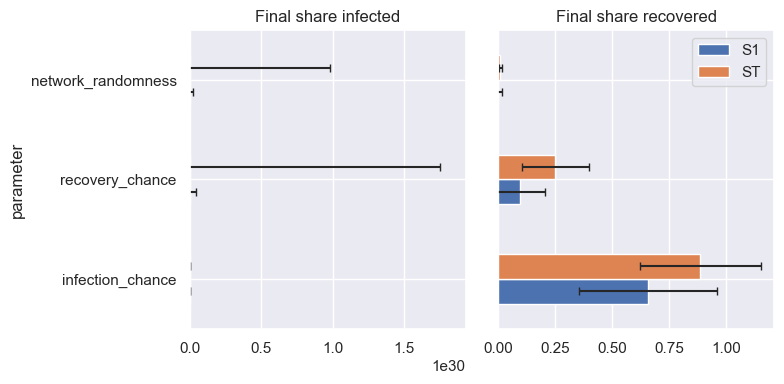

In [90]:
def plot_sobol(results):
    """ Bar plot of Sobol sensitivity indices. """

    sns.set()
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    si_list = results.sensitivity.sobol.groupby(by='reporter')
    si_conf_list = results.sensitivity.sobol_conf.groupby(by='reporter')

    for (key, si), (_, err), ax in zip(si_list, si_conf_list, axs):
        si = si.droplevel('reporter')
        err = err.droplevel('reporter')
        si.plot.barh(xerr=err, title=key, ax=ax, capsize = 3)
        ax.set_xlim(0)

    axs[0].get_legend().remove()
    axs[1].set(ylabel=None, yticklabels=[])
    axs[1].tick_params(left=False)
    plt.tight_layout()

plot_sobol(results)

AttributeError: 'numpy.ndarray' object has no attribute 'get_legend'

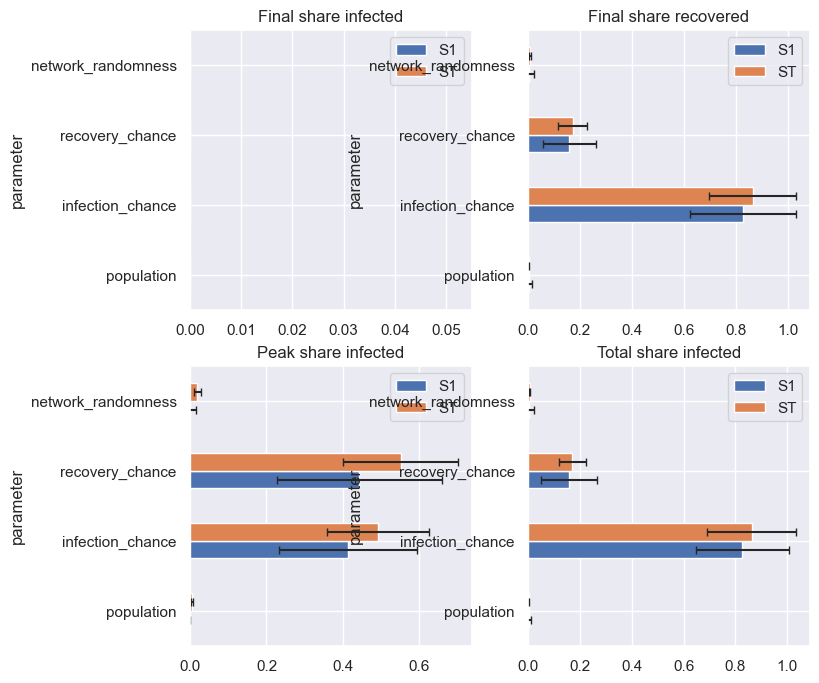

TypeError: 'Axes' object is not iterable

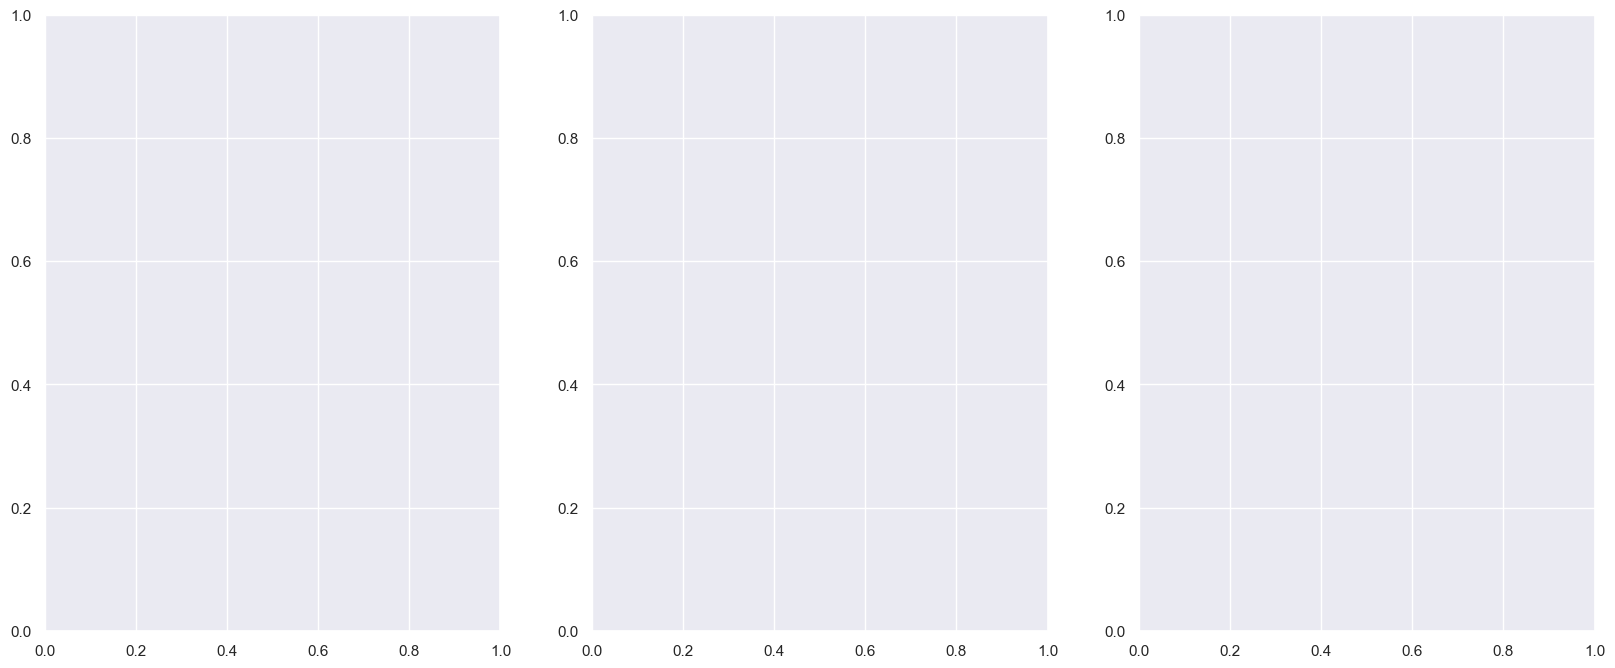

In [95]:
def plot_sensitivity(results):
    """ Show average simulation results for different parameter values. """

    sns.set()
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs = [i for j in axs for i in j] # Flatten list

    data = results.arrange_reporters().astype('float')
    params = results.parameters.sample.keys()

    for x, ax in zip(params, axs):
        for y in results.reporters.columns:
            sns.regplot(x=x, y=y, data=data, ax=ax, ci=99,
                        x_bins=15, fit_reg=False, label=y)
        ax.set_ylim(-1,1)
        ax.set_ylabel('')
        ax.legend()

    plt.tight_layout()

plot_sensitivity(results)

In [122]:
sns.set_theme(style="whitegrid")
sns.set_context("talk")

infection_chance
recovery_chance
network_randomness


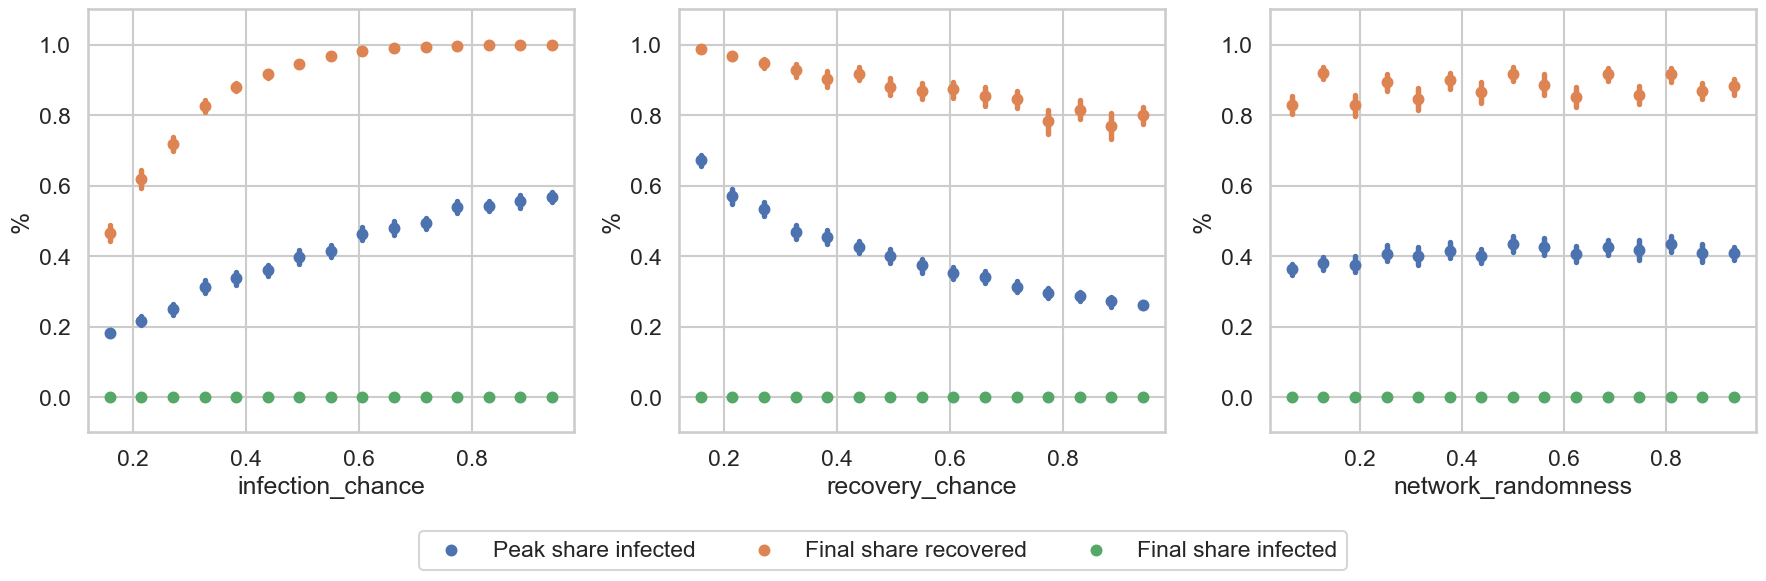

In [126]:
def plot_sensitivity(results):
    """ Show average simulation results for different parameter values. """

    # sns.set()
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    data = results.arrange_reporters().astype('float')
    params = results.parameters.sample.keys()

    for x, ax in zip(params, axs):
        print(x)
        for y in results.reporters.columns:
            if y not in ['seed', 'Total share infected']:
                sns.regplot(x=x, y=y, data=data, ax=ax, ci=99,
                            x_bins=15, fit_reg=False, label=y)
        ax.set_ylim(-0.1,1.1)
        ax.set_ylabel('%')

    ## Get the handles and labels from the last axes object
    handles, labels = axs[-1].get_legend_handles_labels()

    # Create a single legend for the figure
    fig.legend(handles, labels, loc='lower center', ncol=3)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)  # Make space for the legend

plot_sensitivity(results)

In [97]:
results.variables.VirusModel.to_csv('results.txt', sep=' ', index=False)